# Logistics Analysis

In this example, we will analyze the accuracy of a public transit system. The example, is analyzing three lines in Seattle, and it is based on the great blog post [The Waiting Time Paradox, or, Why Is My Bus Always Late?](https://jakevdp.github.io/blog/2018/09/13/waiting-time-paradox/)

[![Open In Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/aiola-lab/from-excel-to-pandas/blob/master/notebooks/08.01_Logistics_analysis.ipynb)

In [1]:
import pandas as pd
import numpy as np

## Loading the data

The data that we have is capturing a couple of bus lines in Seattle, WA. Here is a map of the various lines that operate in the city. 

In [2]:
from IPython.display import Image
Image(url='http://jakevdp.github.io/images/seattle-transit-map.png') 

In [3]:
url = 'https://gist.githubusercontent.com/jakevdp/82409002fcc5142a2add0168c274a869/raw/1bbabf78333306dbc45b9f33662500957b2b6dc3/arrival_times.csv'

import requests
from io import StringIO

response = requests.get(url)
response

<Response [200]>

The CSV file is read through a URL and therefore, we need to convert the text of the response to a simple string as we get when we read a local file. For that we will use the StringIO functionality as follows:

In [4]:
bus_arrival_times = (
    pd
    .read_csv(
        StringIO(
            response.text
        )
    )
)

bus_arrival_times

,OPD_DATE,VEHICLE_ID,RTE,DIR,TRIP_ID,STOP_ID,STOP_NAME,SCH_STOP_TM,ACT_STOP_TM
0,2016-03-26,6201,673,S,30908177,431,3RD AVE & PIKE ST (431),01:11:57,01:13:19
1,2016-03-26,6201,673,S,30908033,431,3RD AVE & PIKE ST (431),23:19:57,23:16:13
2,2016-03-26,6201,673,S,30908028,431,3RD AVE & PIKE ST (431),21:19:57,21:18:46
3,2016-03-26,6201,673,S,30908019,431,3RD AVE & PIKE ST (431),19:04:57,19:01:49
4,2016-03-26,6201,673,S,30908252,431,3RD AVE & PIKE ST (431),16:42:57,16:42:39
...,...,...,...,...,...,...,...,...,...
39152,2016-05-27,6215,674,N,30905957,578,3RD AVE & PIKE ST (578),10:50:25,10:49:50
39153,2016-05-27,6215,674,N,30905720,578,3RD AVE & PIKE ST (578),13:02:27,13:07:10
39154,2016-05-27,6215,674,N,30905729,578,3RD AVE & PIKE ST (578),15:14:29,15:15:55
39155,2016-05-27,6215,674,N,30905740,578,3RD AVE & PIKE ST (578),17:26:29,17:25:40


## Data Exploration

Let's check how many days, buses, routes, trips, stops, etc. do we have in the data.
* Start with the bus arrival times data above
* Convert every cell to string value
* Describe the table (count, unique values, top and frequency)
* Focus only on the unique values count

In [5]:
(
    bus_arrival_times
    .astype(str)
    .describe()
    .loc['unique']
)

OPD_DATE          63
VEHICLE_ID       115
RTE                3
DIR                2
TRIP_ID         1660
STOP_ID            2
STOP_NAME          2
SCH_STOP_TM     1357
ACT_STOP_TM    27633
Name: unique, dtype: object

We see that we have 63 days of data, for 115 buses, in 3 lines (_RTE_) and 2 directions and schedule and arrival times in 2 stops over 1660 trips.

## Data Cleanup

Let's make the data easier to understand and to calculate the accuracy of the lines
* Start with the bus arrival times table above
* Filter out invalid records with _TRIP_ID_ = 0
* Create a _scheduled_ column timestamp with the combination of the date and the scheduled stop time
* Create a _actual_ column timestamp with the combination of the date and the actual stop time
* Calculate the difference between the above timestamps 
* Calculate the difference in minutes by scaling to seconds and then 60 (seconds in a minute)
* Fix the rows that fall across midnights (difference larger than 1000 minutes)
* Add a column with the route symbol (_C_, _D_ or _E_)
* Add a column with the direction of the trip (_northbound_ or _southbound_)
* Focus only on the new columns we created here

In [6]:
trips_accuracy = (
    bus_arrival_times
    .query('TRIP_ID > 0')
    .assign(scheduled = lambda x : pd.to_datetime(x.OPD_DATE + ' ' + x.SCH_STOP_TM, errors='raise'))
    .assign(actual = lambda x : pd.to_datetime(x.OPD_DATE + ' ' + x.ACT_STOP_TM))
    .assign(
        time_diff = lambda x : (x.actual - x.scheduled)
    )
    .assign(
        minutes_late = lambda x : x.time_diff.dt.total_seconds() / 60
    )
    .assign(minutes_late = lambda x: np.where(
        x.minutes_late < 1000, 
        x.minutes_late, 
        x.minutes_late - 60*24)
    )
    .assign(minutes_late = lambda x: np.where(
        x.minutes_late > -1000, 
        x.minutes_late, 
        x.minutes_late + 60*24)
    )
    .assign(route = lambda x: x.RTE.replace({
        673: 'C', 
        674: 'D', 
        675: 'E'})
        .astype('category')
    )
    .assign(direction = lambda x :x.DIR.replace({
        'N': 'northbound', 
        'S': 'southbound'})
        .astype('category')
    )
    .loc[:,['route', 'direction', 'scheduled', 'actual', 'minutes_late']]
)
trips_accuracy

,route,direction,scheduled,actual,minutes_late
0,C,southbound,2016-03-26 01:11:57,2016-03-26 01:13:19,1.366667
1,C,southbound,2016-03-26 23:19:57,2016-03-26 23:16:13,-3.733333
2,C,southbound,2016-03-26 21:19:57,2016-03-26 21:18:46,-1.183333
3,C,southbound,2016-03-26 19:04:57,2016-03-26 19:01:49,-3.133333
4,C,southbound,2016-03-26 16:42:57,2016-03-26 16:42:39,-0.300000
...,...,...,...,...,...
39152,D,northbound,2016-05-27 10:50:25,2016-05-27 10:49:50,-0.583333
39153,D,northbound,2016-05-27 13:02:27,2016-05-27 13:07:10,4.716667
39154,D,northbound,2016-05-27 15:14:29,2016-05-27 15:15:55,1.433333
39155,D,northbound,2016-05-27 17:26:29,2016-05-27 17:25:40,-0.816667


## Data Visualization
### Accuracy Histogram

We can quickly graph the distribution of the accuracy

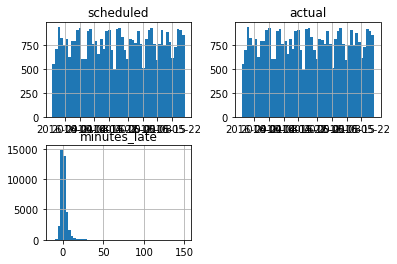

In [7]:
(
    trips_accuracy
    .hist(bins=50)
);

Or even break it down by the different routes and directions to see if the grouops are behaving in a similar way

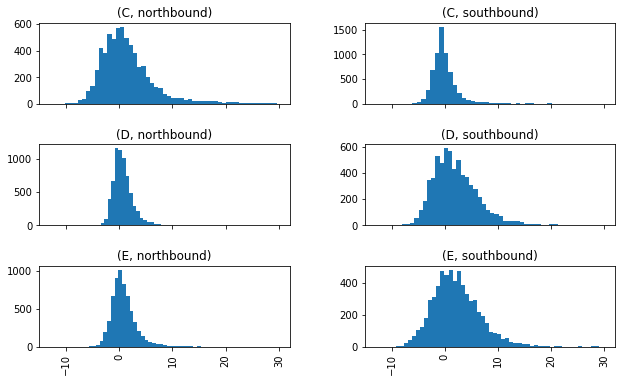

In [8]:
(
    trips_accuracy
    .query('minutes_late < 30')
    .hist(
        bins=50,
        sharex=True, 
        by=['route','direction'], 
        figsize=(10,6)
    )
);

### Fancier Visualization

The default visualization functionality of Pandas is often enhanced with a set of graphic libraries that we will cover in a dedicated chapter. Here is an improved visualization using Seaborn.

In [9]:
%pip install seaborn --quiet

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Note: you may need to restart the kernel to use updated packages.


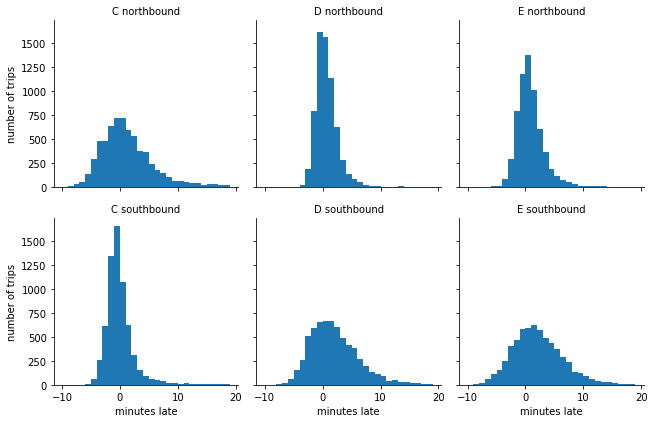

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
g = (
    sns
    .FacetGrid(
        trips_accuracy, 
        row="direction", 
        col="route"
    )
)

g.map(
    plt.hist, 
    "minutes_late", 
    bins=np.arange(-10, 20)
)
g.set_titles('{col_name} {row_name}')
g.set_axis_labels('minutes late', 'number of trips');

You might expect that the buses stick closer to their schedule near the beginning of each one-way trip and show more spread near the end, and this is borne out in the data: the southbound C-line and northbound D and E lines are near the beginning of their respective routes, and in the opposite direction they are near the end.

## Scheduled and Actual Arrival Intervals

* Start with the trips_accuracy table above
* Sort the value based on the Scheduled time
* Group by _route_ and _direction_
* Focus only on the Scheduled and actual time columns
* calculate the diff between every adjacent trips in each Group
* Convert null values to 0
* Convert the time delta values to minutes
* Merge with the original table based on the similar index of both tables
* Change the name of the column from the diff table to include the suffix _interval

In [11]:
trips_intervals = (
    trips_accuracy
    .sort_values('scheduled')
    .groupby(['route', 'direction'])
    ['scheduled','actual']
    .diff()
    .fillna(pd.Timedelta(seconds=0))
    .astype('timedelta64[m]')
    .merge(
        trips_accuracy,
        left_index=True, 
        right_index=True,
        suffixes=("_interval","")
    )
)
trips_intervals

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


,scheduled_interval,actual_interval,route,direction,scheduled,actual,minutes_late
19512,0.0,0.0,C,northbound,2016-03-26 00:00:25,2016-03-26 00:05:01,4.600000
79,0.0,0.0,C,southbound,2016-03-26 00:04:57,2016-03-26 00:05:18,0.350000
19725,0.0,0.0,D,northbound,2016-03-26 00:05:25,2016-03-26 00:05:06,-0.316667
155,0.0,0.0,E,southbound,2016-03-26 00:27:59,2016-03-26 00:28:04,0.083333
19569,0.0,0.0,E,northbound,2016-03-26 00:28:10,2016-03-26 00:29:46,1.600000
...,...,...,...,...,...,...,...
19462,15.0,13.0,D,southbound,2016-05-27 23:44:58,2016-05-27 23:45:36,0.633333
4609,15.0,16.0,C,southbound,2016-05-27 23:49:57,2016-05-27 23:49:35,-0.366667
9735,30.0,27.0,E,southbound,2016-05-27 23:53:59,2016-05-27 23:57:15,3.266667
29313,30.0,30.0,E,northbound,2016-05-27 23:55:10,2016-05-27 23:54:09,-1.016667


We can see that we have a few issues with the midnights and some of the interval are a day apart. Previously, we fixed it in the flow, however, now we can use a function that is fixing this issues on a specific column to simplify our code. 
* Start with the given table 
* If the value is smaller than 1,000 
* Assign to the given column name the original value of the column 
* Otheriwse, assign a value that is (60 minutes by 24 hours) minutes smaller
* Repeat for values that are larger than -1,000

In [12]:
def fix_midnights(df, col_name):
    fixed_df = (
        df
        .assign(**{col_name : lambda x: np.where(
            x[col_name] < 1_000, 
            x[col_name], 
            x[col_name] - 60*24)}
        )
        .assign(**{col_name : lambda x: np.where(
            x[col_name] > -1_000, 
            x[col_name], 
            x[col_name] + 60*24)}
        )
    )
    return fixed_df

Now that we have a business logic function that can fix the midnight problem that we saw in our data, we can apply on the two problematic columns in our table:
* Start with the trip intervals table above
* Fix the midnight problem in scheduled_interval column
* Fix the midnight problem in actual_interval column

In [13]:
fixed_trip_intervals = (
    trips_intervals
    .pipe(fix_midnights, 'scheduled_interval')
    .pipe(fix_midnights, 'actual_interval')
)
fixed_trip_intervals

,scheduled_interval,actual_interval,route,direction,scheduled,actual,minutes_late
19512,0.0,0.0,C,northbound,2016-03-26 00:00:25,2016-03-26 00:05:01,4.600000
79,0.0,0.0,C,southbound,2016-03-26 00:04:57,2016-03-26 00:05:18,0.350000
19725,0.0,0.0,D,northbound,2016-03-26 00:05:25,2016-03-26 00:05:06,-0.316667
155,0.0,0.0,E,southbound,2016-03-26 00:27:59,2016-03-26 00:28:04,0.083333
19569,0.0,0.0,E,northbound,2016-03-26 00:28:10,2016-03-26 00:29:46,1.600000
...,...,...,...,...,...,...,...
19462,15.0,13.0,D,southbound,2016-05-27 23:44:58,2016-05-27 23:45:36,0.633333
4609,15.0,16.0,C,southbound,2016-05-27 23:49:57,2016-05-27 23:49:35,-0.366667
9735,30.0,27.0,E,southbound,2016-05-27 23:53:59,2016-05-27 23:57:15,3.266667
29313,30.0,30.0,E,northbound,2016-05-27 23:55:10,2016-05-27 23:54:09,-1.016667


## Data Visualization
### Actual Intervals Distribution

* Create grid of graphs from the fixed trip intervals table
* each row will have a different direction
* each column will have a different route
* In each graph create an histogram with the actual interval value
* with bins between 0 and 50
* Add a title for each graph with the route and direction
* Add labels to the axis

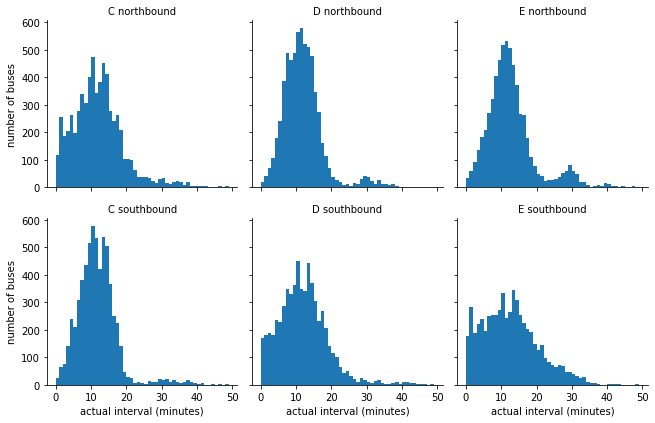

In [14]:
g = (
    sns
    .FacetGrid(
        fixed_trip_intervals, 
        row="direction", 
        col="route"
    )
)
g.map(
    plt.hist, 
    "actual_interval", 
    bins=np.arange(50)
)
g.set_titles('{col_name} {row_name}')
g.set_axis_labels('actual interval (minutes)', 'number of buses');

the distributions may be affected by non-constant scheduled arrival intervals. Let's understand the different intervals that are scheduled. We will repeat the graphs logic above and plot the _schedule interval_ instead of the actual ones. 

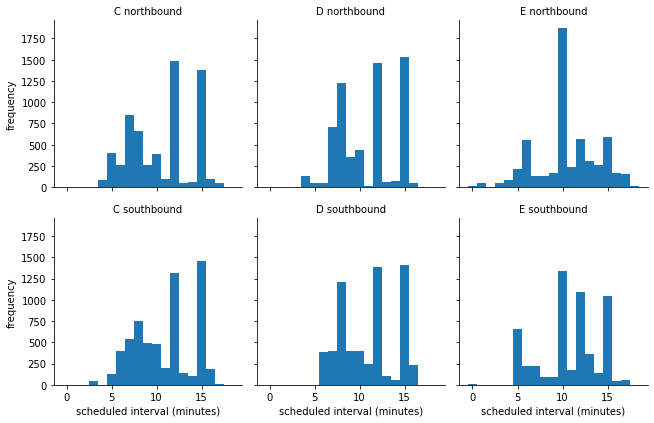

In [15]:
g = (
    sns
    .FacetGrid(
        fixed_trip_intervals, 
        row="direction", 
        col="route"
    )
)
g.map(plt.hist, "scheduled_interval", bins=np.arange(20) - 0.5)
g.set_titles('{col_name} {row_name}')
g.set_axis_labels('scheduled interval (minutes)', 'frequency');

### Heat Maps
We can see the most of the lines have 7, 12 and 15 minutes interval for most of the trips. If we to see the heat map of the interval plans, we can add the hour and the day-of-week (dow) to the table using _eval_:
* Start with the fixed trip intervals table above
* Add a column with the hour in the day of each trip
* Add a column with the name of the day in the week
* Convert the name of the day to be an ordered category based on the day names from the calendar (it will make the order of the days in the graph to be as expected and not alphabetic)

In [16]:
from pandas.api.types import CategoricalDtype
import calendar
trip_intervals_with_time = (
    fixed_trip_intervals
    .eval("hour = scheduled.dt.hour")
    .assign(dow = lambda x : x.scheduled.dt.day_name().astype(
        CategoricalDtype(
            ordered=True, 
            categories=list(calendar.day_name))
        )
    )
)
trip_intervals_with_time

,scheduled_interval,actual_interval,route,direction,scheduled,actual,minutes_late,hour,dow
19512,0.0,0.0,C,northbound,2016-03-26 00:00:25,2016-03-26 00:05:01,4.600000,0,Saturday
79,0.0,0.0,C,southbound,2016-03-26 00:04:57,2016-03-26 00:05:18,0.350000,0,Saturday
19725,0.0,0.0,D,northbound,2016-03-26 00:05:25,2016-03-26 00:05:06,-0.316667,0,Saturday
155,0.0,0.0,E,southbound,2016-03-26 00:27:59,2016-03-26 00:28:04,0.083333,0,Saturday
19569,0.0,0.0,E,northbound,2016-03-26 00:28:10,2016-03-26 00:29:46,1.600000,0,Saturday
...,...,...,...,...,...,...,...,...,...
19462,15.0,13.0,D,southbound,2016-05-27 23:44:58,2016-05-27 23:45:36,0.633333,23,Friday
4609,15.0,16.0,C,southbound,2016-05-27 23:49:57,2016-05-27 23:49:35,-0.366667,23,Friday
9735,30.0,27.0,E,southbound,2016-05-27 23:53:59,2016-05-27 23:57:15,3.266667,23,Friday
29313,30.0,30.0,E,northbound,2016-05-27 23:55:10,2016-05-27 23:54:09,-1.016667,23,Friday


To plot the heatmap we will use the built-in heatmap graph of Seaborn library:
* Start with the trip intervals table with the hour and dow above
* Take only the _hour_, _dow_ and _scheduled interval_ columns
* Create a pivot table with _hour_ as the index and _dow_ as columns (with mean as default aggregation function)
* Clip values that are larger than 60 minutes to 60
* Remove the first level of the columns names (the name of the calculated column _scheduled interval_)

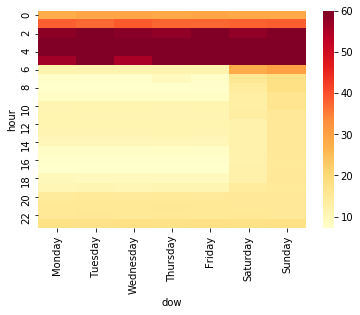

In [17]:
sns.heatmap(
    trip_intervals_with_time
    [['hour','dow','scheduled_interval']]
    .pivot_table(index='hour', columns='dow')
    .clip(upper=60)
    .droplevel(0, axis='columns'),
    cmap="YlOrRd"
);

As expected the larger intervals are during the night (between midnight and 5 AM) and the shortest are during the rush hours of the morning and afternoon. We can also see the Saturday and Sunday have longer interval as expected.

Let's check how the actual arrival times behave across the week and create a similar heatmap of the _minute late_ column that we calculated above. 

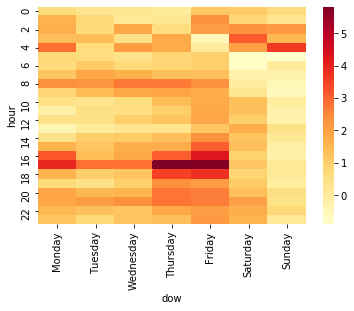

In [18]:
sns.heatmap(
    trip_intervals_with_time
    [['hour','dow','minutes_late']]
    .pivot_table(index='hour', columns='dow')
    .clip(upper=60)
    .droplevel(0, axis='columns'),
    cmap="YlOrRd"
);

Most of the problems are at 5 PM mostly on Monday, Thursday and Friday. We can also see some higher delay on the last shift of the night at 4 AM, however, it is probably not affecting that many people like the delays of the rush hours of the afternoon. 

Let's break it down by route:

In [19]:
minutes_late_heatmap_by_route = (
    trip_intervals_with_time
    [['hour','dow','minutes_late','route']]
    .pivot_table(index=['route','hour'], columns=['dow'])
    .clip(upper=60)
    .droplevel(0, axis='columns')
)

### Heatmap as a table with values

This time we will create the heat map more similar to the way it will be presented in Excel using style (similar to Conditional Formatting in Excel):
* Start with the pivot table per route
* Apply style to table
* Format the values to be with up to 2 digits of precision
* Apply conditional backgroud to each cell with gradient from yellow to orange to red

In [20]:
(
    minutes_late_heatmap_by_route
    .style
    .format("{:.2}", na_rep="-")
    .background_gradient(cmap='YlOrRd')
)

Now it is easy to see the 5-7 minutes delays during the rush hours of the C and D routes. We can also explore other problemaic times on Saturday, etc. 